# **Modelo**

## Split de conjuntos

Hago un check de la data que voy a usar en el modelo

---



In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406448 entries, 0 to 406447
Data columns (total 42 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   POLICY_ID              406448 non-null  float64       
 1   INSR_BEGIN             406448 non-null  datetime64[ns]
 2   INSR_END               406448 non-null  datetime64[ns]
 3   CUSTOMER_SENIORITY     406448 non-null  float64       
 4   SEX                    406448 non-null  object        
 5   INSR_TYPE              406448 non-null  object        
 6   INSURED_VALUE          406448 non-null  float64       
 7   PREMIUM                406439 non-null  float64       
 8   VEHICLE_ID             406448 non-null  float64       
 9   USAGE                  406448 non-null  object        
 10  CLAIM_PAID             33040 non-null   float64       
 11  PROD_YEAR              406448 non-null  float64       
 12  SEATS_NUM              406421 non-null  floa



---

Hago una copia del df, quito lo que no voy a usar y hago el split de sets

---



In [ ]:
# Copio el dataframe
df_copy = df.copy()
# Cambio la columna iv positivo a valor numerico
df_copy['iv_positivo'] = df_copy['iv_positivo'].astype(int)

# Sacamos variables que no voy a usar en el modelo
exclude_vars = ['INSR_BEGIN', 'INSR_END', 'CLAIM_PAID','MAKE']
df_copy = df_copy.drop(columns=exclude_vars)

# Imputamos nulos con la media
numeric_cols = df_copy.select_dtypes(include=['float64', 'int64']).columns.tolist()
numeric_preprocessor = SimpleImputer(strategy='mean')
df_copy[numeric_cols] = numeric_preprocessor.fit_transform(df_copy[numeric_cols])

# Hacemos one-hot encoding para categoricas
categorical_columns = df_copy.select_dtypes(include=['object']).columns
df_copy = pd.get_dummies(df_copy, columns=categorical_columns)

# Claim como variable objetivo y el resto como predictoras
X = df_copy.drop(columns=['CLAIM'])
y = df_copy['CLAIM']

# Comenzamos con un split aleatorio, eventualmente balanceamos las clases
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=7)

# Veo las dimensiones
print("Dimensiones de Train set:", X_train.shape, y_train.shape)
print("Dimensiones de Validation set:", X_val.shape, y_val.shape)

Dimensiones de Train set: (325158, 74) (325158,)
Dimensiones de Validation set: (81290, 74) (81290,)




---
**Comentario:** debido a que la empresa está interesada en predecir quienes van a realizar un reclamo de siniestro, voy a utilizar la métrica de Recall para elegir el mejor modelo, ya que es la proporción de siniestros que predigo bien sobre el universo total de siniestros. Puesto en otros términos: true positives / (true positives + false negatives)

Eventualmente, si fuera costoso para la empresa predecir muchos false positive (lo cual disminuye precision), porque, por ejemplo, ajustan el precio de las primas para ellos, podría buscarse un equilibrio con la métrica f1

---



## Modelos




### Regresión logística


In [ ]:
# Inicializo y ajusto el modelo de regresión logística
logistic_model = LogisticRegression(random_state=7)
logistic_model.fit(X_train, y_train)

# Predigo en conjuntos de entrenamiento y validación
y_train_pred = logistic_model.predict(X_train)
y_val_pred = logistic_model.predict(X_val)

# Calculo métricas
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)

precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)

# Calculo métricas para cada clase
classification_rep = classification_report(y_val, y_val_pred, target_names=['No reclama', 'Reclama'])

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Precision: {precision:.4f}")
print(f"Validation Recall: {recall:.4f}")
print(f"Validation F1-Score: {f1:.4f}")

# Métricas por clase
print()
print("Classification Report:")
print(classification_rep)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Accuracy: 0.9191
Validation Accuracy: 0.9176
Validation Precision: 0.0000
Validation Recall: 0.0000
Validation F1-Score: 0.0000

Classification Report:
              precision    recall  f1-score   support

  No reclama       0.92      1.00      0.96     74590
     Reclama       0.00      0.00      0.00      6700

    accuracy                           0.92     81290
   macro avg       0.46      0.50      0.48     81290
weighted avg       0.84      0.92      0.88     81290



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Comentario:**

Este modelo de regresión logística con los datos provistos no alcanza a detectar los reclamos, ya que tiene un Recall de 0


### Random Forest



In [ ]:
# Crear el modelo Random Forest
random_forest_model = RandomForestClassifier(
                                            n_estimators=150,
                                            max_depth=10,
                                            min_samples_split=2,
                                            min_samples_leaf=1,
                                            random_state=7)
# Entrenar el modelo en el conjunto de entrenamiento
random_forest_model.fit(X_train, y_train)

# Predecir en el conjunto de entrenamiento
y_train_pred = random_forest_model.predict(X_train)

# Predecir en el conjunto de validación
y_val_pred = random_forest_model.predict(X_val)

# Calcular métricas para el conjunto de entrenamiento
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)

# Calcular métricas para el conjunto de validación
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)

# Imprimir resultados
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Precision: {precision:.4f}")
print(f"Validation Recall: {recall:.4f}")
print(f"Validation F1-Score: {f1:.4f}")

# Imprimir métricas por clase
print()
print("Classification Report:")
print(classification_rep)

Training Accuracy: 0.9194
Validation Accuracy: 0.9177
Validation Precision: 0.0000
Validation Recall: 0.0000
Validation F1-Score: 0.0000

Classification Report:
              precision    recall  f1-score   support

  No reclama       0.92      1.00      0.96     74590
     Reclama       0.00      0.00      0.00      6700

    accuracy                           0.92     81290
   macro avg       0.46      0.50      0.48     81290
weighted avg       0.84      0.92      0.88     81290



**Comentario:**

Este modelo de random forest con los datos provistos tampoco alcanza a detectar los reclamos, ya que tiene un Recall de 0



---

**Creo una muestra con mayor preponderacia de la clase minoritaria**

---


In [ ]:
# Creo una instancia de SMOTE
smote = SMOTE(random_state=7)

# Aplico SMOTE al conjunto de entrenamiento
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [ ]:
print("Proporción de reclamos en base original: " + str(y_train.sum() / len(y_train)))
print("Proporción de reclamos en base resampleada: " + str(y_train_resampled.sum() / len(y_train_resampled)))

Proporción de reclamos en base original: 0.08089913211423369
Proporción de reclamos en base resampleada: 0.5



---

**Random Forest con muestra mejor balanceada**

---



In [ ]:
# Creo y entreno el modelo balanceado
balanced_model_rf = RandomForestClassifier(
                                            n_estimators=150,
                                            max_depth=10,
                                            min_samples_split=2,
                                            min_samples_leaf=1,
                                            random_state=7)
balanced_model_rf.fit(X_train_resampled, y_train_resampled)

# Predecir en el conjunto de entrenamiento
y_train_pred = balanced_model_rf.predict(X_train_resampled)

# Predecir en el conjunto de validación
y_val_pred = balanced_model_rf.predict(X_val)

# Calcular métricas para el conjunto de entrenamiento
train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
train_precision = precision_score(y_train_resampled, y_train_pred)
train_recall = recall_score(y_train_resampled, y_train_pred)
train_f1 = f1_score(y_train_resampled, y_train_pred)

# Calcular métricas para el conjunto de validación
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)

# Armo df con las métricas
metrics_df = pd.DataFrame({
    'Metrica': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Entrenamiento': [train_accuracy, train_precision, train_recall, train_f1],
    'Validacion': [val_accuracy, val_precision, val_recall, val_f1]
})
metrics_df = metrics_df.set_index('Metrica')

# Calcular métricas para cada clase
classification_rep = classification_report(y_val, y_val_pred, target_names=['No reclama', 'Reclama'])


print("Resultados en train y validación")
print(metrics_df)

# Imprimir métricas por clase
print()
print("Classification Report:")
print(classification_rep)

Resultados en train y validación
           Entrenamiento  Validacion
Metrica                             
Accuracy        0.866538    0.769627
Precision       0.823819    0.165340
Recall          0.932499    0.443433
F1-Score        0.874797    0.240869

Classification Report:
              precision    recall  f1-score   support

  No reclama       0.94      0.80      0.86     74590
     Reclama       0.17      0.44      0.24      6700

    accuracy                           0.77     81290
   macro avg       0.55      0.62      0.55     81290
weighted avg       0.88      0.77      0.81     81290



**Comentario:**

Solo con rebalancear la muestra, el modelo ya alcanza un recall de 0,44

---

**Random Forest con muestra mejor balanceada y optimización de hiperparámetros manual**

---


In [ ]:
# Creo y entreno el modelo balanceado
balanced_model_rf = RandomForestClassifier(
                                            n_estimators=300,
                                            max_depth=5,
                                            min_samples_split=2,
                                            min_samples_leaf=1,
                                            random_state=7)
balanced_model_rf.fit(X_train_resampled, y_train_resampled)

# Predecir en el conjunto de entrenamiento
y_train_pred = balanced_model_rf.predict(X_train_resampled)

# Predecir en el conjunto de validación
y_val_pred = balanced_model_rf.predict(X_val)

# Calcular métricas para el conjunto de entrenamiento
train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
train_precision = precision_score(y_train_resampled, y_train_pred)
train_recall = recall_score(y_train_resampled, y_train_pred)
train_f1 = f1_score(y_train_resampled, y_train_pred)

# Calcular métricas para el conjunto de validación
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)

# Armo df con las métricas
metrics_df = pd.DataFrame({
    'Metrica': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Entrenamiento': [train_accuracy, train_precision, train_recall, train_f1],
    'Validacion': [val_accuracy, val_precision, val_recall, val_f1]
})
metrics_df = metrics_df.set_index('Metrica')

# Calcular métricas para cada clase
classification_rep = classification_report(y_val, y_val_pred, target_names=['No reclama', 'Reclama'])


print("Resultados en train y validación")
print(metrics_df)

# Imprimir métricas por clase
print()
print("Classification Report:")
print(classification_rep)

Resultados en train y validación
           Entrenamiento  Validacion
Metrica                             
Accuracy        0.788473    0.639390
Precision       0.720588    0.147406
Recall          0.942346    0.705522
F1-Score        0.816681    0.243861

Classification Report:
              precision    recall  f1-score   support

  No reclama       0.96      0.63      0.76     74590
     Reclama       0.15      0.71      0.24      6700

    accuracy                           0.64     81290
   macro avg       0.55      0.67      0.50     81290
weighted avg       0.89      0.64      0.72     81290



**Comentario:**

Manteniendo la muestra rebalanceada y luego de cierta optimización manual de hiperparámetros, este random forest consigue un recall de 0,71

---

**Random Forest con muestra mejor balanceada y optimización de hiperparámetros manual - última versión**

---

Este es el modelo que dio el mejor resultado de los que probé al momento

In [ ]:
# Creo y entreno el modelo balanceado
balanced_model_rf = RandomForestClassifier(
                                            n_estimators=200,
                                            max_depth=3,
                                            min_samples_split=2,
                                            min_samples_leaf=1,
                                            random_state=7)
balanced_model_rf.fit(X_train_resampled, y_train_resampled)

# Predecir en el conjunto de entrenamiento
y_train_pred = balanced_model_rf.predict(X_train_resampled)

# Predecir en el conjunto de validación
y_val_pred = balanced_model_rf.predict(X_val)

# Calcular métricas para el conjunto de entrenamiento
train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
train_precision = precision_score(y_train_resampled, y_train_pred)
train_recall = recall_score(y_train_resampled, y_train_pred)
train_f1 = f1_score(y_train_resampled, y_train_pred)

# Calcular métricas para el conjunto de validación
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)

# Armo df con las métricas
metrics_df = pd.DataFrame({
    'Metrica': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Entrenamiento': [train_accuracy, train_precision, train_recall, train_f1],
    'Validacion': [val_accuracy, val_precision, val_recall, val_f1]
})
metrics_df = metrics_df.set_index('Metrica')

# Calcular métricas para cada clase
classification_rep = classification_report(y_val, y_val_pred, target_names=['No reclama', 'Reclama'])


print("Resultados en train y validación")
print(metrics_df)

# Imprimir métricas por clase
print()
print("Classification Report:")
print(classification_rep)

Resultados en train y validación
           Entrenamiento  Validacion
Metrica                             
Accuracy        0.739096    0.547989
Precision       0.666202    0.141189
Recall          0.958388    0.882239
F1-Score        0.786020    0.243421

Classification Report:
              precision    recall  f1-score   support

  No reclama       0.98      0.52      0.68     74590
     Reclama       0.14      0.88      0.24      6700

    accuracy                           0.55     81290
   macro avg       0.56      0.70      0.46     81290
weighted avg       0.91      0.55      0.64     81290



**Comentario:**

El modelo de random forest, optimizando hiperparámetros manualmente, que mejor performó fue este, con un recall de 0,88


---

**Feature importance para las 15 variables más explicativas del último modelo**

---


<ipython-input-99-f58f6bc39680>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Importance', y='Feature', data=top_15_features, palette='viridis')


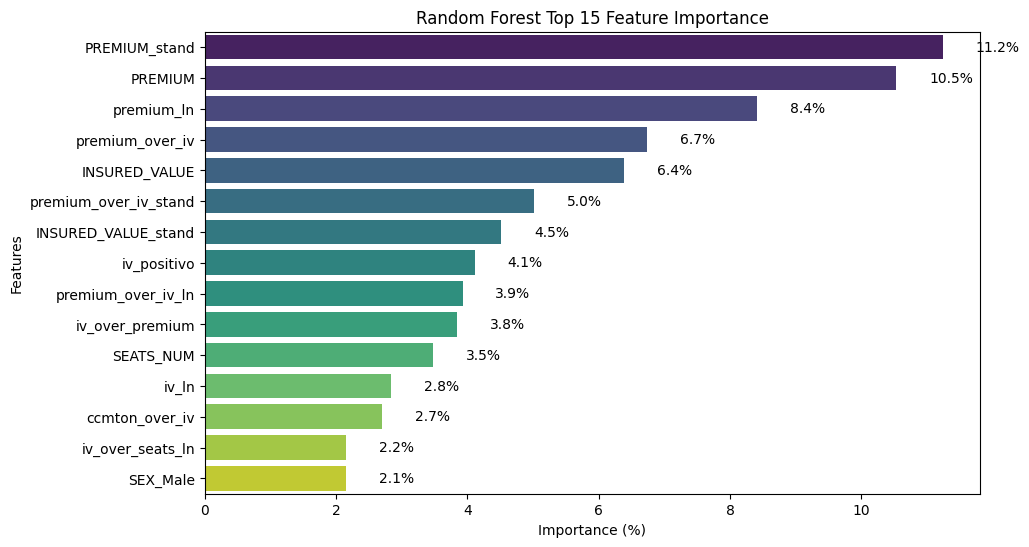

In [ ]:
# Obtener importancia de las características
importances = balanced_model_rf.feature_importances_
feature_names = X_train_resampled.columns

# Calcular importancias relativas en porcentajes
relative_importances = 100 * (importances / importances.sum())

# Crear un DataFrame con las características y sus importancias relativas
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': relative_importances})

# Ordenar el DataFrame por importancia en orden descendente
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Seleccionar las primeras 15 variables más importantes
top_15_features = feature_importance_df.head(15)

# Graficar la importancia de las características
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Importance', y='Feature', data=top_15_features, palette='viridis')
plt.title('Random Forest Top 15 Feature Importance')
plt.xlabel('Importance (%)')
plt.ylabel('Features')

# Agregar etiquetas de porcentaje a la derecha de cada barra
for index, value in enumerate(top_15_features['Importance']):
    ax.text(value + 0.5, index, f'{value:.1f}%', ha='left', va='center', color='black', fontsize=10)

plt.show()


**Comentario:**

Las primeras diez variables refieren a la prima, el valor asegurado y transformaciones de ellas, acumulando el 64,7% del poder explicativo del modelo. Ello podría ser un indicio de que al volver hacia atrás y realizar un feature engenieering más exhaustivo sobre esas variables probablemente se pueda conseguir un modelo más preciso para distinguir las clases.


### Xgboost


---

**Grid Search para xgboost**

---


Habiendo probado varios valores de hiperparámetros y teniendo un sense de por dónde mejora el modelo de Xgboost que armé, voy a hacer gridsearch para diferentes valores



In [ ]:
# Defino los valores para el grid search
param_grid = {
    'colsample_bytree': [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9],
    'max_depth': [2,3, 4],
    'n_estimators': [100, 200, 300, 500]
}

# Creo el modelo base
base_model = XGBClassifier(
    objective='binary:logistic',
    learning_rate=0.001,
    subsample=0.9,
    random_state=7
)

# Inicializo GridSearchCV
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring='recall',
    cv=3,  # Número de divisiones en la validación cruzada
    verbose=1,
    n_jobs=-1  # Usar todos los núcleos disponibles
)

# Realizar la búsqueda en la cuadrícula
grid_search.fit(X_train_resampled, y_train_resampled)

# Obtener los mejores parámetros y el mejor modelo
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Imprimir resultados
print("Mejores parámetros:", best_params)
print("Mejor modelo:", best_model)

# Predecir en el conjunto de validación con el mejor modelo
y_val_pred_best = best_model.predict(X_val)

# Calcular métricas para el conjunto de validación con el mejor modelo
val_recall_best = recall_score(y_val, y_val_pred_best)

# Imprimir recall con el mejor modelo
print(f"Recall con los mejores parámetros en el conjunto de validación: {val_recall_best:.4f}")


Fitting 3 folds for each of 84 candidates, totalling 252 fits
Mejores parámetros: {'colsample_bytree': 0.6, 'max_depth': 2, 'n_estimators': 200}
Mejor modelo: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=7, ...)
Recall con los mejores parámetros en el conjunto de validación: 0.8313


---

**XGboost con muestra mejor balanceada y optimización de hiperparámetros**

---


Entreno el modelo que mejor performó en el grid search

In [ ]:
# Crear y entrenar el modelo XGBoost en el conjunto de entrenamiento balanceado
# xgb_model = XGBClassifier(random_state=7)
xgb_model = XGBClassifier(
    objective='binary:logistic',
    learning_rate=0.001,
    n_estimators=200,
    max_depth=2,
    subsample=0.9,
    colsample_bytree=0.6,
    random_state=7
)

xgb_model.fit(X_train_resampled, y_train_resampled)

# Predecir en el conjunto de entrenamiento
y_train_pred = xgb_model.predict(X_train_resampled)

# Predecir en el conjunto de validación
y_val_pred = xgb_model.predict(X_val)

# Calcular métricas para el conjunto de entrenamiento
train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
train_precision = precision_score(y_train_resampled, y_train_pred)
train_recall = recall_score(y_train_resampled, y_train_pred)
train_f1 = f1_score(y_train_resampled, y_train_pred)

# Calcular métricas para el conjunto de validación
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)

# Armo df con las métricas
metrics_df = pd.DataFrame({
    'Metrica': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Entrenamiento': [train_accuracy, train_precision, train_recall, train_f1],
    'Validacion': [val_accuracy, val_precision, val_recall, val_f1]
})
metrics_df = metrics_df.set_index('Metrica')

# Calcular métricas para cada clase
classification_rep = classification_report(y_val, y_val_pred, target_names=['No reclama', 'Reclama'])

# Resultados
print("Resultados en train y validación")
print(metrics_df)

# Imprimir métricas por clase
print()
print("Classification Report:")
print(classification_rep)

Resultados en train y validación
           Entrenamiento  Validacion
Metrica                             
Accuracy        0.732491    0.550117
Precision       0.664288    0.135817
Recall          0.940061    0.831343
F1-Score        0.778473    0.233489

Classification Report:
              precision    recall  f1-score   support

  No reclama       0.97      0.52      0.68     74590
     Reclama       0.14      0.83      0.23      6700

    accuracy                           0.55     81290
   macro avg       0.55      0.68      0.46     81290
weighted avg       0.90      0.55      0.64     81290



**Comentario:**

Luego de la optimización de hiperparámetros el modelo alcanza un recall de 0,83

---

**Feature importance para las 15 variables más explicativas del último modelo**

---


<ipython-input-61-674bc659a3be>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Importance', y='Feature', data=top_15_features, palette='viridis')


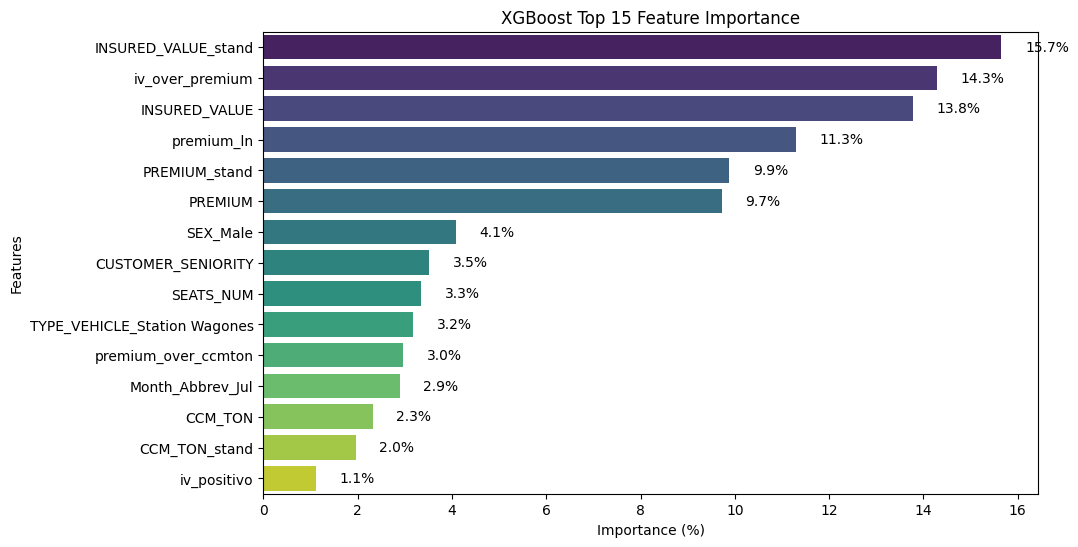

In [ ]:
importances = xgb_model.feature_importances_
feature_names = X_train.columns

# Calcular importancias relativas en porcentajes
relative_importances = 100 * (importances / importances.sum())

# Crear un DataFrame con las características y sus importancias relativas
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': relative_importances})

# Ordenar el DataFrame por importancia en orden descendente
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Seleccionar las primeras 15 variables más importantes
top_15_features = feature_importance_df.head(15)

# Graficar la importancia de las características
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Importance', y='Feature', data=top_15_features, palette='viridis')
plt.title('XGBoost Top 15 Feature Importance')
plt.xlabel('Importance (%)')
plt.ylabel('Features')

# Agregar etiquetas de porcentaje a la derecha de cada barra
for index, value in enumerate(top_15_features['Importance']):
    ax.text(value + 0.5, index, f'{value:.1f}%', ha='left', va='center', color='black', fontsize=10)

plt.show()



**Comentario:**

Al ver cuánto poder explicativo aporta cada variable al modelo, se observa las 5 primeras variables aportan el 74,7% del poder explicativo. Donde las 5 variables son en realidad el valor asegurado, la prima y algunas transformaciones de ellas. A diferencia del mejor modelo de random forest, acá pareciera tener más importancia el valor asegurado, mientras que allá la prima. Además, hay menos features que concentran mayor poder explicativo


### Red neuronal


---

**Red neuronal con dos capas ocultas de 64 y 32 neuronas respectivamente**

---


In [ ]:
# Inicializar y ajustar el modelo de red neuronal densa
dense_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_resampled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # 1 neurona de salida para clasificación binaria
])

dense_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[keras.metrics.Recall(), keras.metrics.Precision(), 'accuracy', keras.metrics.F1Score()])

# Entrenar el modelo en el conjunto de entrenamiento balanceado
dense_model.fit(X_train_resampled, y_train_resampled, epochs=8, batch_size=64, validation_data=(X_val, y_val))

# Evaluar el modelo en el conjunto de validación
dense_model.evaluate(X_val, y_val)

Epoch 1/8
9340/9340 [==============================] - 26s 3ms/step - loss: nan - recall_2: 2.0077e-04 - precision_2: 0.5405 - accuracy: 0.5000 - f1_score: 4.0139e-04 - val_loss: nan - val_recall_2: 0.0000e+00 - val_precision_2: 0.0000e+00 - val_accuracy: 0.9176 - val_f1_score: 0.0000e+00
Epoch 2/8
9340/9340 [==============================] - 23s 2ms/step - loss: nan - recall_2: 0.0000e+00 - precision_2: 0.0000e+00 - accuracy: 0.5000 - f1_score: 0.0000e+00 - val_loss: nan - val_recall_2: 0.0000e+00 - val_precision_2: 0.0000e+00 - val_accuracy: 0.9176 - val_f1_score: 0.0000e+00
Epoch 3/8
9340/9340 [==============================] - 23s 2ms/step - loss: nan - recall_2: 0.0000e+00 - precision_2: 0.0000e+00 - accuracy: 0.5000 - f1_score: 0.0000e+00 - val_loss: nan - val_recall_2: 0.0000e+00 - val_precision_2: 0.0000e+00 - val_accuracy: 0.9176 - val_f1_score: 0.0000e+00
Epoch 4/8
9340/9340 [==============================] - 23s 3ms/step - loss: nan - recall_2: 0.0000e+00 - precision_2: 0.00

[nan, 0.0, 0.0, 0.9175790548324585, array([0.], dtype=float32)]

**Comentario:**

Aún entrenando la red neuronal con los conjuntos rebalanceados y después de probar diferentes arquitecturas no consigo mejorar el recall que se mantiene en 0 para el conjunto de validación


## Elección del modelo final y predicción de test


La decisión de dedicar mayor tiempo a optimizar los modelos de Random Forest y Xgboost responde, por un lado, al hecho de que son modelos que manejan bien datos categóricos y numéricos al mismo tiempo, y por otro, a que al entrenar y ensamblar árboles con una submuestra de filas y columnas permite reducir overfitting y generar mejor entendimiento de cuáles son las variables que mayor poder explicativo aportan.

**Elección de modelo final:**  para predecir los resultados en test voy a elegir el random forest que obtuvo un recall de 0,88. Para ello, antes debo hacerle a la base de test el mismo feature engenieering que a la base de entrenamiento.

### Ajustes en set de test

In [ ]:
test = df_test.merge(df_ve, on='VEHICLE_ID', how='left')
test.head()

,POLICY_ID,INSR_BEGIN,INSR_END,CUSTOMER_SENIORITY,SEX,INSR_TYPE,INSURED_VALUE,PREMIUM,VEHICLE_ID,USAGE,PROD_YEAR,SEATS_NUM,CARRYING_CAPACITY,TYPE_VEHICLE,CCM_TON,MAKE
0,300439992.0,2017-08-08,2018-08-07,0.0,Male,1202,0.00,347.70,5.000995e+09,Fare Paying Passengers,2016.0,3.0,0.0,Motor-cycle,200.0,BAJAJI
1,300476572.0,2017-08-08,2018-08-07,2.0,Female,1201,1515442.28,17045.52,5.001114e+09,Private,2015.0,8.0,NaN,Station Wagones,4164.0,MITSUBISHI
2,300485215.0,2017-08-08,2018-08-07,0.0,Female,1201,3200000.00,18088.33,5.001174e+09,Private,2017.0,8.0,NaN,Station Wagones,4164.0,TOYOTA
3,300477745.0,2017-08-08,2018-08-07,0.0,Female,1201,418528.41,5140.66,5.001113e+09,Private,2017.0,4.0,NaN,Automobile,2400.0,BAIC
4,300477746.0,2017-08-08,2018-08-07,0.0,Female,1201,418528.41,5140.66,5.001113e+09,Private,2017.0,4.0,NaN,Automobile,2400.0,BAIC




---

Me fijo que los nulos tengan distirbución parecida al set de entrenamiento

---



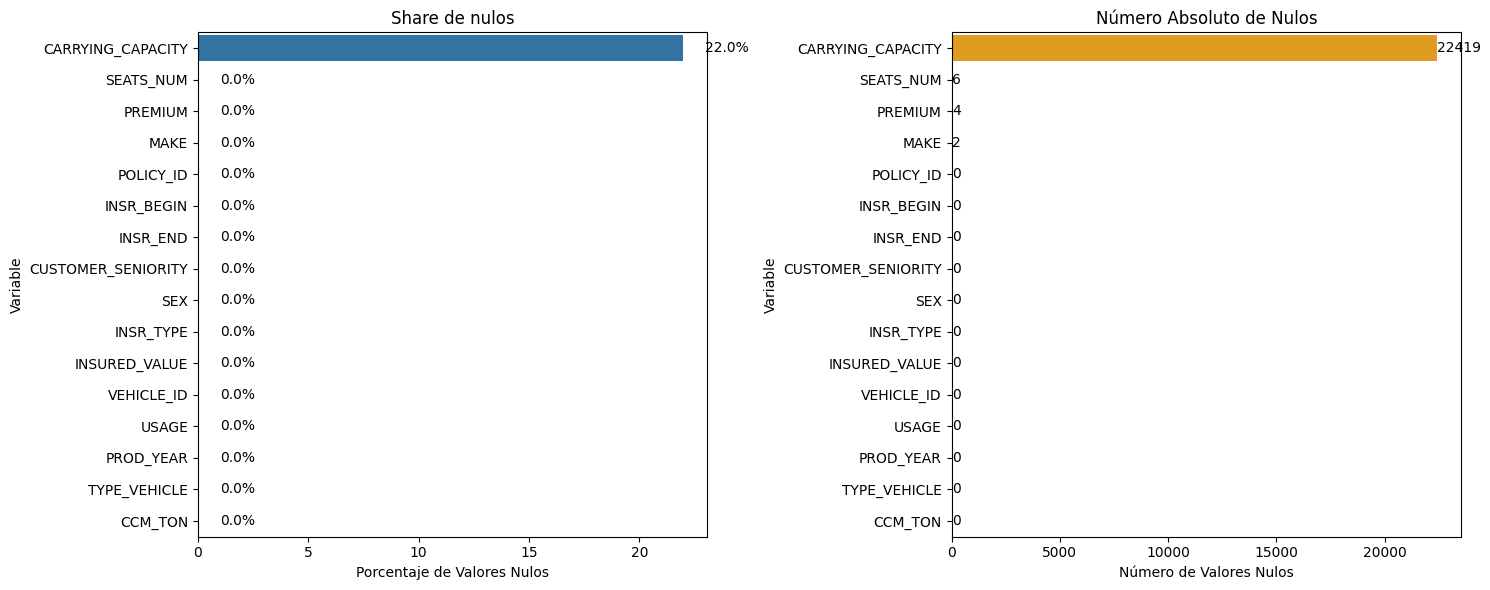

In [ ]:
porcentaje_nulos = (test.isnull().sum() / len(test)) * 100
num_nulos = test.isnull().sum()

# Armo df para visualizar el share de nulos
df_porcentaje_nulos = pd.DataFrame({'Variable': porcentaje_nulos.index, 'Porcentaje_Nulos': porcentaje_nulos.values})

# Ordeno por porcentaje descendente
df_porcentaje_nulos = df_porcentaje_nulos.sort_values(by='Porcentaje_Nulos', ascending=False)

# Gráfico de share de nulos
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
barplot_share = sns.barplot(x='Porcentaje_Nulos', y='Variable', data=df_porcentaje_nulos)
plt.title('Share de nulos')
plt.xlabel('Porcentaje de Valores Nulos')

# Añadir etiquetas de porcentaje de nulos
for index, value in enumerate(df_porcentaje_nulos['Porcentaje_Nulos']):
    barplot_share.text(value + 1, index, f'{value:.1f}%', va='center')

# Armo df para visualizar el número absoluto de nulos
df_num_nulos = pd.DataFrame({'Variable': num_nulos.index, 'Num_Nulos': num_nulos.values})

# Ordeno por número absoluto de nulos descendente
df_num_nulos = df_num_nulos.sort_values(by='Num_Nulos', ascending=False)

# Gráfico de número absoluto de nulos
plt.subplot(1, 2, 2)
barplot_num = sns.barplot(x='Num_Nulos', y='Variable', data=df_num_nulos, color='orange')
plt.title('Número Absoluto de Nulos')
plt.xlabel('Número de Valores Nulos')

# Añadir etiquetas de número absoluto de nulos
for index, value in enumerate(df_num_nulos['Num_Nulos']):
    barplot_num.text(value + 1, index, f'{value}', va='center')

plt.tight_layout()
plt.show()


In [ ]:
test.describe()

,POLICY_ID,CUSTOMER_SENIORITY,INSURED_VALUE,PREMIUM,VEHICLE_ID,PROD_YEAR,SEATS_NUM,CARRYING_CAPACITY,CCM_TON
count,1.019880e+05,101988.000000,1.019880e+05,101984.000000,1.019880e+05,101988.000000,101982.000000,79569.000000,101988.000000
mean,3.003385e+08,4.661990,5.124256e+05,7443.237315,5.000789e+09,2008.280739,5.503628,238.860718,2797.795365
std,1.526447e+05,6.175821,9.106809e+05,11649.278709,3.816030e+05,9.334425,11.556062,2345.872712,3321.797600
min,3.000000e+08,0.000000,0.000000e+00,0.000000,5.000018e+09,1950.000000,0.000000,0.000000,0.000000
25%,3.002083e+08,1.000000,0.000000e+00,462.700000,5.000503e+09,2004.000000,1.000000,0.000000,200.000000
50%,3.003891e+08,2.000000,0.000000e+00,1949.300000,5.000875e+09,2012.000000,3.000000,0.000000,1971.000000
75%,3.004804e+08,6.000000,8.000000e+05,9052.392500,5.001136e+09,2015.000000,4.000000,10.000000,4164.000000
max,3.005084e+08,59.000000,3.625609e+07,185301.700000,5.001351e+09,2018.000000,198.000000,224000.000000,19980.000000


**Comentario:**

Armo este describe para comparar que las variables se distribuyan mas o menos de manera parecida al set con el que entrené. Veo algunas diferencias en seniority, insured value, premium y carrying capacity, lo cual podría afectar las predicciones en test

In [ ]:
# Armo algunos campos relativos, dejando na cuando estoy por dividir por cero
test['iv_positivo'] = test['INSURED_VALUE'].apply(lambda x: 1 if x > 0 else 0).astype(str)
test['premium_over_iv'] = np.where(test['INSURED_VALUE'] != 0, test['PREMIUM'] / test['INSURED_VALUE'], np.nan)
test['iv_over_premium'] = np.where(test['PREMIUM'] != 0, test['INSURED_VALUE'] / test['PREMIUM'], np.nan)
test['iv_over_seats'] = np.where(test['SEATS_NUM'] != 0, test['INSURED_VALUE'] / test['SEATS_NUM'], np.nan)
test['premium_over_seats'] = np.where(test['SEATS_NUM'] != 0, test['PREMIUM'] / test['SEATS_NUM'], np.nan)
test['iv_over_capacity'] = np.where(test['CARRYING_CAPACITY'] != 0, test['INSURED_VALUE'] / test['CARRYING_CAPACITY'], np.nan)
test['premium_over_ccmton'] = np.where(test['CCM_TON'] != 0, test['PREMIUM'] / test['CCM_TON'], np.nan)
test['ccmton_over_premium'] = np.where(test['PREMIUM'] != 0, test['CCM_TON'] / test['PREMIUM'], np.nan)
test['iv_over_ccmton'] = np.where(test['CCM_TON'] != 0, test['INSURED_VALUE'] / test['CCM_TON'], np.nan)
test['ccmton_over_iv'] = np.where(test['INSURED_VALUE'] != 0, test['CCM_TON'] / test['INSURED_VALUE'], np.nan)

# Imputar nulos como el máximo de cada variable elevado a la 5
variables_relativas = ['premium_over_iv', 'iv_over_premium', 'iv_over_seats', 'premium_over_seats',
                       'iv_over_capacity', 'premium_over_ccmton', 'ccmton_over_premium', 'iv_over_ccmton', 'ccmton_over_iv']

for variable in variables_relativas:
    test[variable].fillna(test[variable].max() ** 5, inplace=True)

# Tomo el mes de la fecha
test['Month_Abbrev'] = test['INSR_BEGIN'].dt.strftime('%b')

In [ ]:
# Imputo el valor máximo elevado a la 4 para aquellos valores donde el divisor es cero
max_values = {}  # Diccionario para almacenar el valor máximo de cada columna

columnas = ['premium_over_iv', 'iv_over_premium', 'iv_over_seats', 'premium_over_seats',
            'iv_over_capacity', 'premium_over_ccmton', 'ccmton_over_premium', 'iv_over_ccmton',
            'ccmton_over_iv']

# Máximo para cada columna
for column in columnas:
    max_values[column] = test[column].replace([np.inf, -np.inf], np.nan).max()

# Recorro el df y reemplazo
for column in columnas:
    test[column].fillna(max_values[column] ** 4, inplace=True)

selected = ['premium_over_iv', 'iv_over_premium']

# Si tanto la prima como el insured value son cero, entonces adopta el valor nan
# ((test['INSURED_VALUE'] == 0) & (test['PREMIUM'] == 0)).sum() Esto me dice que hay una sola instancia donde premium y insured value son ambas cero. Ahi tengo que imputar un nan
# Imputo un nan
indices_condicion = test[(test['INSURED_VALUE'] == 0) & (test['PREMIUM'] == 0)].index
test.loc[indices_condicion, selected] = np.nan


In [ ]:
# Tomo ln a algunos campos y agrego un epsilon muy pequeño para que el log(0) no me tire NaN
epsilon = 1e-10

test['premium_over_iv_ln'] = np.log(test['premium_over_iv'] + epsilon)
test['iv_over_premium_ln'] = np.log(test['iv_over_premium'] + epsilon)
test['iv_ln'] = np.log(test['INSURED_VALUE'] + epsilon)
test['premium_ln'] = np.log(test['PREMIUM'] + epsilon)
test['iv_over_seats_ln'] = np.log(test['iv_over_seats'] + epsilon)
test['premium_over_seats_ln'] = np.log(test['premium_over_seats'] + epsilon)
test['iv_over_capacity_ln'] = np.log(test['iv_over_capacity'] + epsilon)

In [ ]:
# Estandarizo
columns_to_standardize = ['PREMIUM', 'INSURED_VALUE', 'CCM_TON', 'premium_over_iv', 'ccmton_over_iv', 'iv_over_premium']

scaler = MinMaxScaler()
for column in columns_to_standardize:
    new_column_name = f"{column}_stand"
    test[new_column_name] = scaler.fit_transform(test[[column]])

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101988 entries, 0 to 101987
Data columns (total 40 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   POLICY_ID              101988 non-null  float64       
 1   INSR_BEGIN             101988 non-null  datetime64[ns]
 2   INSR_END               101988 non-null  datetime64[ns]
 3   CUSTOMER_SENIORITY     101988 non-null  float64       
 4   SEX                    101988 non-null  object        
 5   INSR_TYPE              101988 non-null  object        
 6   INSURED_VALUE          101988 non-null  float64       
 7   PREMIUM                101984 non-null  float64       
 8   VEHICLE_ID             101988 non-null  float64       
 9   USAGE                  101988 non-null  object        
 10  PROD_YEAR              101988 non-null  float64       
 11  SEATS_NUM              101982 non-null  float64       
 12  CARRYING_CAPACITY      79569 non-null   floa

In [ ]:
test_copy = test

# Cambio la columna iv positivo a valor numerico
test_copy['iv_positivo'] = test_copy['iv_positivo'].astype(int)

# Sacamos variables que no voy a usar en el modelo
exclude_vars = ['INSR_BEGIN', 'INSR_END', 'MAKE']
test_copy = test_copy.drop(columns=exclude_vars)

# Imputamos nulos con la media
numeric_cols = test_copy.select_dtypes(include=['float64', 'int64']).columns.tolist()
numeric_preprocessor = SimpleImputer(strategy='mean')
test_copy[numeric_cols] = numeric_preprocessor.fit_transform(test_copy[numeric_cols])

# Hacemos one-hot encoding para categoricas
categorical_columns = test_copy.select_dtypes(include=['object']).columns
test_copy = pd.get_dummies(test_copy, columns=categorical_columns)

# Veo las dimensiones
print("Dimensiones de Test set:", test_copy.shape)


Dimensiones de Test set: (101988, 73)


Al set le falta una columna, probablemente sea algun valor de una variable categórica que no aparece en test, y por ende no se creó su columna con one-hot encoding

In [ ]:
# Obtener conjuntos de nombres de columnas
columns_X_train = set(X_train.columns)
columns_test = set(test_copy.columns)

# Encontrar las columnas que están en X_train pero no en test
missing_columns = columns_X_train - columns_test

# Imprimir el resultado
if missing_columns:
    print("Las siguientes columnas están en X_train pero no en test:")
    for column in missing_columns:
        print(column)
else:
    print("No hay columnas en X_train que no estén en test.")

Las siguientes columnas están en X_train pero no en test:
Month_Abbrev_Jul


Agrego la columna en el orden donde aparece en el set de entrenamiento

In [ ]:
# Obtener la posición de 'Month_Abbrev_Jun'
index_jun = list(test_copy.columns).index('Month_Abbrev_Jun')

# Insertar 'Month_Abbrev_Jul' después de 'Month_Abbrev_Jan'
test_copy.insert(index_jun, 'Month_Abbrev_Jul', 0)

### Entrenamiento sobre test resampleado

In [ ]:
# Creo y entreno el modelo balanceado
balanced_model_rf = RandomForestClassifier(
                                            n_estimators=200,
                                            max_depth=3,
                                            min_samples_split=2,
                                            min_samples_leaf=1,
                                            random_state=7)
balanced_model_rf.fit(X_train_resampled, y_train_resampled)

# Predecir en el conjunto de entrenamiento
y_test_pred = balanced_model_rf.predict(test_copy)

In [ ]:
y_test_pred

array([0., 1., 1., ..., 0., 0., 0.])

In [ ]:

# Crear un DataFrame con el vector
pred = pd.DataFrame({'pred': y_test_pred})

# Guardar el DataFrame como un archivo CSV
pred.to_csv('pred.csv', index=False)

# Descargar
files.download('pred.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>